## Imports

In [1]:
import rospy
import time
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import Button, Layout
import actionlib
from geometry_msgs.msg import Twist
from move_base_msgs.msg import MoveBaseAction, MoveBaseGoal
from tf import transformations
import matplotlib.pyplot as plt
from nav_msgs.msg import Odometry
from matplotlib.animation import FuncAnimation
from sensor_msgs.msg import LaserScan
from actionlib_msgs.msg import GoalStatusArray

%matplotlib notebook
%matplotlib notebook
%matplotlib notebook

### Teleoperation Buttons Definitions

In [2]:
vel = Twist()
third = False
ok_left = True
ok_straight = True
ok_right = True

vl = 1
publ = rospy.Publisher('/cmd_vel', Twist, queue_size = 1)
straight_button = widgets.Button(description = 'Go Forward', layout=Layout(width='20%', height='50px'), button_style='info')
straight_button.style.button_color = 'lightgreen'
back_button = widgets.Button(description = 'Go Back', layout=Layout(width='20%', height='50px'), button_style='info')
back_button.style.button_color = 'lightgreen'
left_button = widgets.Button(description = 'Turn Left', layout=Layout(width='20%', height='50px'), button_style='info')
left_button.style.button_color = 'lightgreen'
right_button = widgets.Button(description = 'Turn Right', layout=Layout(width='20%', height='50px'), button_style='info')
right_button.style.button_color = 'lightgreen'
straight_right_button = widgets.Button(description = 'Go straight-right', layout=Layout(width='20%', height='50px'), button_style='primary')
straight_left_button = widgets.Button(description = 'Go straight-left', layout=Layout(width='20%', height='50px'), button_style='primary')
increase_button = widgets.Button(description = 'Increase Velocities', layout=Layout(width='60%', height='50px'), button_style='info')
increase_button.style.button_color = 'green'
reset_button = widgets.Button(description = 'Reset Velocities', layout=Layout(width='60%', height='50px'), button_style='warning')
stop_button = widgets.Button(description = 'Stop', layout=Layout(width='60%', height='50px'), button_style='danger')

def straight_button_clicked(b):
    global vel
    global vl
    
    if ok_straight == True: # No obstacles detected in the front direction 
        vel.linear.x = vl
        vel.linear.y = 0
        vel.linear.z = 0
        vel.angular.x = 0
        vel.angular.y = 0
        vel.angular.z = 0
        publ.publish(vel) # Publishing on /cmd_vel the new command
    else:
        print("Command 'Go Straight' disabled")
    
straight_button.on_click(straight_button_clicked)

def back_button_clicked(b):
    global vel
    global vl
    
    vel.linear.x = -vl
    vel.linear.y = 0
    vel.linear.z = 0
    vel.angular.x = 0
    vel.angular.y = 0
    vel.angular.z = 0
    publ.publish(vel) # Publishing on /cmd_vel the new command
    
back_button.on_click(back_button_clicked)  

def left_button_clicked(b):
    global vel
    global vl
    
    if ok_left == True: # No obstacles detected on the left  
        vel.linear.x = 0
        vel.linear.y = 0
        vel.linear.z = 0
        vel.angular.x = 0
        vel.angular.y = 0
        vel.angular.z = vl
        publ.publish(vel) # Publishing on /cmd_vel the new command
    else:
        print("Command 'Go Left' disabled")

left_button.on_click(left_button_clicked)
    
def right_button_clicked(b):
    global vel
    global vl
    
    if ok_right == True: # No obstacles detected on the right 
        vel.linear.x = 0
        vel.linear.y = 0
        vel.linear.z = 0
        vel.angular.x = 0
        vel.angular.y = 0
        vel.angular.z = -vl
        publ.publish(vel) # Publishing on /cmd_vel the new command
    else:
        print("Command 'Go Right' disabled")

right_button.on_click(right_button_clicked)

def straight_left_button_clicked(b):
    global vel
    global vl
    
    if ok_left == True and ok_straight == True: # No obstacles detected on the left and in the front direction
        vel.linear.x = vl
        vel.linear.y = 0
        vel.linear.z = 0
        vel.angular.x = 0
        vel.angular.y = 0
        vel.angular.z = vl/2
        publ.publish(vel) # Publishing on /cmd_vel the new command
    else:
        print("Command 'Go Straight' disabled")
        print("Command 'Go Left' disabled")

straight_left_button.on_click(straight_left_button_clicked)
    
def straight_right_button_clicked(b):
    global vel
    global vl
    
    if ok_straight == True and ok_right == True: # No obstacles detected on the right and in the front direction
        vel.linear.x = vl
        vel.linear.y = 0
        vel.linear.z = 0
        vel.angular.x = 0
        vel.angular.y = 0
        vel.angular.z = -vl/2
        publ.publish(vel) # Publishing on /cmd_vel the new command
    else:
        print("Command 'Go Straight' disabled")
        print("Command 'Go Right' disabled")

straight_right_button.on_click(straight_right_button_clicked)
    
def increase_v_button_clicked(b):
    global vl
    vl = vl + 1 # Increase velocity constant

increase_button.on_click(increase_v_button_clicked)

def reset_v_button_clicked(b):
    global vl
    vl = 1

reset_button.on_click(reset_v_button_clicked)

def stop_button_clicked(b):
    vel.linear.x = 0
    vel.linear.y = 0
    vel.linear.z = 0
    vel.angular.x = 0
    vel.angular.y = 0
    vel.angular.z = 0
    publ.publish(vel) # Publishing on /cmd_vel the new command
    
stop_button.on_click(stop_button_clicked)

row1=widgets.HBox([straight_left_button, straight_button, straight_right_button])
row2=widgets.HBox([left_button, back_button, right_button])
row3=widgets.HBox([stop_button])
row4=widgets.HBox([increase_button])
row5=widgets.HBox([reset_button])

## Modality Selection and Buttons' callbacks definition

In [3]:
rospy.init_node("jupyter_ui")
output = widgets.Output()

des_x = widgets.FloatText(
    value=0,
    description='X:',
    disabled=False
)
des_y = widgets.FloatText(
    value=0,
    description='Y:',
    disabled=False
)

boxes = widgets.HBox([des_x, des_y])

cancel_button = widgets.Button(description = 'Click Me to cancel the goal!', layout=Layout(width='50%', height='80px'), button_style='danger')

def cancel_button_clicked(b):
    rospy.set_param('active', 0)
    
    
cancel_button.on_click(cancel_button_clicked)
    
ok_button = widgets.Button(description = 'Send Goal', layout=Layout(width='30%', height='30px'), button_style='')

def ok_button_clicked(b):

    rospy.set_param('active', 0)
    rospy.set_param('des_pos_x', des_x.value)
    rospy.set_param('des_pos_y', des_y.value)
    rospy.set_param('active', 1) 
    
ok_button.on_click(ok_button_clicked)
    
button_first_mod = widgets.Button(description = 'Click Me to choose the first modality!', layout=Layout(width='50%', height='80px'), button_style='info')
def first_button_clicked(b):
    print("You chose the first controlling modality")
    third = False
    display(des_x)
    display(des_y)
    display(ok_button)
    display(cancel_button)
    
button_first_mod.on_click(first_button_clicked)

button_second_mod = widgets.Button(description = 'Click Me to choose the second modality!', layout=Layout(width='50%', height='80px'), button_style='info')

def second_button_clicked(b):
    third = False
    rospy.set_param('active', 0)
    rospy.set_param('active', 2)
    display(row1)
    display(row2)
    display(row3)
    display(row4)
    display(row5)
    
    
button_second_mod.on_click(second_button_clicked)

button_third_mod = widgets.Button(description = 'Click Me to choose the third modality!', layout=Layout(width='50%', height='80px'), button_style='info')


def clbk_laser(msg):
    global vel
    global ok_left
    global ok_right
    global ok_straight

    right = min(min(msg.ranges[0:143]), 1)      # Detects obstacles on the right of the robot
    front = min(min(msg.ranges[288:431]), 1)    # Detects obstacles in front of the robot
    left = min(min(msg.ranges[576:719]), 1)     # Detects obstacles on the left of the robot
    
     # If the robot is moving towards an obstalcle I have to stop it
    if right != 1.0 and vel.angular.z < 0: 
        
        ok_right =False
        vel.angular.z = 0 # Stop the robot 

    else:         
        ok_right =True

    if front != 1.0 and vel.linear.x > 0:  
        ok_straight = False
        vel.linear.x = 0 # Stop the robot 

    else:              
        ok_straight =True

    if left != 1.0 and vel.angular.z > 0:    
        ok_left =False
        vel.angular.z = 0 # Stop the robot 

    else:            
        ok_left =True
        
    publ.publish(vel) # Publishing on /cmd_vel the new command

def third_button_clicked(b):
    third=True
    rospy.set_param('active', 0)
    rospy.set_param('active', 3)
    display(row1)
    display(row2)
    display(row3)
    display(row4)
    display(row5)
    
button_third_mod.on_click(third_button_clicked)


sub = rospy.Subscriber('/scan', LaserScan, clbk_laser) # Laser scan subscription. Needed for obstacle avoidance. 
buttons = widgets.HBox([button_first_mod, button_second_mod, button_third_mod])
widgets.VBox([buttons, output])
    


You chose the first controlling modality


FloatText(value=0.0, description='X:')

FloatText(value=0.0, description='Y:')

Button(description='Send Goal', layout=Layout(height='30px', width='30%'), style=ButtonStyle())

Button(button_style='danger', description='Click Me to cancel the goal!', layout=Layout(height='80px', width='…

## Data visualization. 
### Robot position, Sensor Array and Reached Goals 

<IPython.core.display.Javascript object>


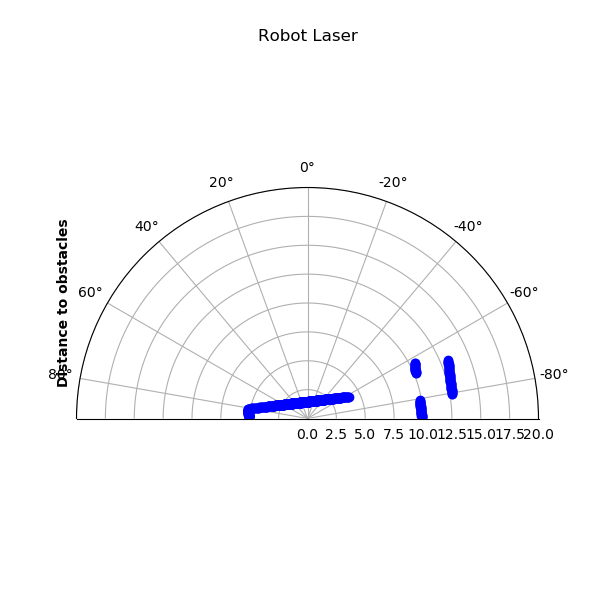

<IPython.core.display.Javascript object>


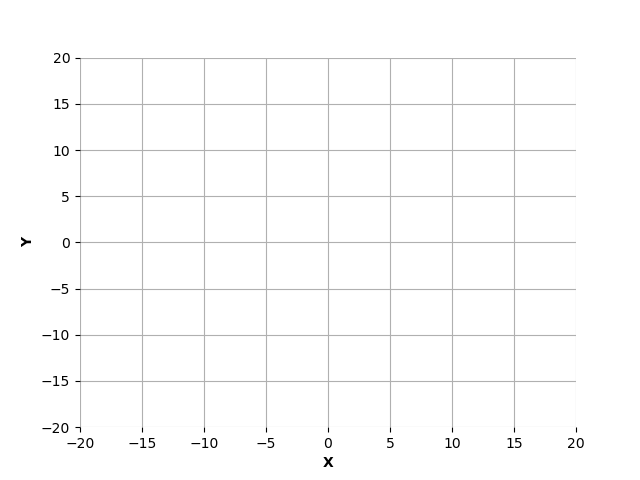

<IPython.core.display.Javascript object>


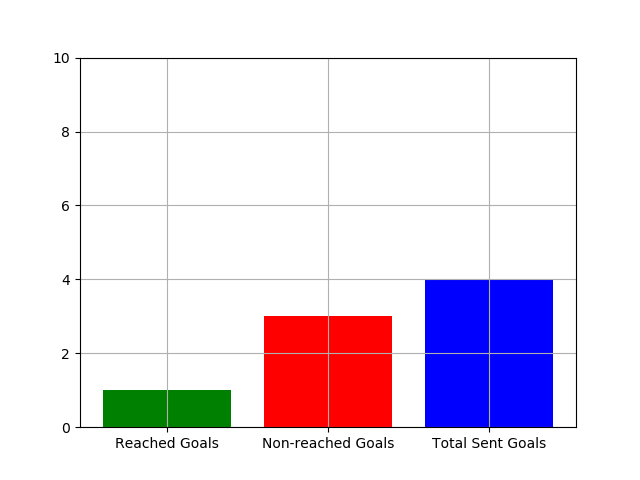

In [4]:
angles = []

class Visualiser:
    # This class is needed for creating animated plots 
    def __init__(self):
        
        #Polar plot for laser scan data initial settings
        self.fig_laser = plt.figure(figsize=(6,6))
        self.ax_laser = plt.subplot(111, polar=True)
        self.ax_laser.set_thetalim(-np.pi/2,np.pi/2)
        self.ax_laser.set_theta_zero_location("N")
       
        self.ln_laser, = self.ax_laser.plot([],[],'bo')
        
        # Odometry plot initial settings
        self.fig_odom, self.ax_odom = plt.subplots()
        plt.grid(True)
        self.ln_odom, = plt.plot([] ,[], 'bo')
        
        # Reached / Non-Reached goals initial settings
        self.achieved = False
        self.goal_counter = 0
        self.non_reached_goal_counter = 0
        self.laser  = [] 
        self.x_pos, self.y_pos = [], []

        self.fig_target, self.ax_target = plt.subplots()
        plt.grid(True)
        self.status_list = [0, 0]
        self.data = {'Reached Goals': self.goal_counter, 
                     'Non-reached Goals':self.non_reached_goal_counter, 
                     'Total Sent Goals': self.goal_counter + self.non_reached_goal_counter}
        
        self.target = list(self.data.keys())
        self.values = list(self.data.values())
        self.ln_target = plt.bar(self.target, self.values, color=("green", "red", "blue"))
        
              
    def plot_init(self):
        
        # Setting plot axis 
        self.ax_laser.set_title("Robot Laser")
        self.ax_laser.set_ylabel("Distance to obstacles",fontweight="bold")
        
        self.ax_odom.set_xlim(-20, 20)
        self.ax_odom.set_ylim(-20, 20)

        self.ax_odom.set_title("Robot Position",fontweight="bold")
        self.ax_odom.set_ylabel("Y",fontweight="bold")
        self.ax_odom.set_xlabel("X",fontweight="bold")

        self.ax_target.set_ylim(0, 10)
        
        return self.ln_laser , self.ln_odom, self.ln_target
    
    def scan_callback(self, msg):
        global angles
        # evenly spaced values within "msg.angle_increment" interval
        angles = list(np.arange(msg.angle_min, msg.angle_max+msg.angle_increment, msg.angle_increment))
        self.laser=list(msg.ranges)
        
    def odom_callback(self, msg):
        self.y_pos.append(msg.pose.pose.position.y)
        self.x_pos.append(msg.pose.pose.position.x)
        
    def goal_cb(self, msg): 

        try: 
            # Array that contains the status numbers of the action server 
            self.status_list.append(msg.status_list[0].status)

            if self.status_list[-1] == 3 and self.status_list[-2] != 3: # status = 3 -> Reached goals
                self.goal_counter = self.goal_counter + 1

            elif self.status_list[-1] == 2 and self.status_list[-2] != 2: # Non Reached goals, status = 2 -> cancel request
                self.non_reached_goal_counter = self.non_reached_goal_counter + 1

            elif self.status_list[-1] == 4 and self.status_list[-2] != 2: # Non Reached goals, status = 4 -> impossible goal target. 
                self.non_reached_goal_counter = self.non_reached_goal_counter + 1

        except IndexError:
            pass
            
        
    # Updating plots for animation
    def update_plot_odom(self, frame):
        x = self.x_pos
        y = self.y_pos
        self.ln_odom.set_data(x, y)
        return self.ln_odom
    
    def update_plot_target(self, frame):
        x = self.goal_counter
        y = self.non_reached_goal_counter
        z = self.goal_counter + self.non_reached_goal_counter
        self.updated_data = {'Reached Goals': x, 
                             'Non-reached Goals': y, 
                             'Total Sent Goals': z}
        
        h = list(self.updated_data.values())
        q = list(self.updated_data.keys())
        
        self.ln_target = plt.bar(q, h, color=("green", "red", "blue"))
        
        return self.ln_target
    
    def update_polar(self, frame):
        global angles    
        self.ax_laser.set_rmax(20)
        self.ln_laser.set_data(angles,self.laser)
        return self.ln_laser
    

    
vis = Visualiser()
sub_scan = rospy.Subscriber("/scan", LaserScan, vis.scan_callback)
sub_odom = rospy.Subscriber("/odom", Odometry, vis.odom_callback)
sub_status = rospy.Subscriber("/move_base/status", GoalStatusArray, vis.goal_cb)
# Animating plots
ani_laser = FuncAnimation(vis.fig_laser, vis.update_polar, blit = True)
ani_odom = FuncAnimation(vis.fig_odom, vis.update_plot_odom, init_func=vis.plot_init)
ani_target = FuncAnimation(vis.fig_target, vis.update_plot_target, init_func=vis.plot_init, interval=100)

plt.show(block = True)